In [1]:
import sys
sys.path.insert(0, "../")


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ctgan.synthesizers.ctgan import CTGANSynthesizer
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

from src.data_loader import load_covid_dataset
from src.utils import *

seed = 0
seed_everything(seed)


/home/rob/miniconda3/envs/3s/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load datasets

In [2]:
_, _, df = load_covid_dataset(drop_SG_UF_NOT=False)

In [3]:
north = [
    "AM"
]  # ['BA','PA','PE','CE','MA','PB','RN','AL','PI','SE','RO','TO','AP','RR', 'AM']
south = ["SP"]  # ['SP','MG','RJ','RS','PR','SC','GO','MT','DF','MS']


south_ids = list(df[df["SG_UF_NOT"].isin(south)].index)
north_ids = df[df["SG_UF_NOT"].isin(north)].index


In [4]:
X_test = df.iloc[north_ids, :]
X_train = df.iloc[south_ids, :]

X_train = X_train.drop(columns=["SG_UF_NOT"])
X_test = X_test.drop(columns=["SG_UF_NOT"])
X_train.shape, X_test.shape


((4111, 22), (424, 22))

# Fit CTGAN

In [5]:
discrete_columns = [
    "Sex_male",
    "Fever",
    "Cough",
    "Sore_throat",
    "Shortness_of_breath",
    "Respiratory_discomfort",
    "SPO2",
    "Dihareea",
    "Vomitting",
    "Cardiovascular",
    "Asthma",
    "Diabetis",
    "Pulmonary",
    "Immunosuppresion",
    "Obesity",
    "Liver",
    "Neurologic",
    "Renal",
    "y",
]  


syn_model = CTGANSynthesizer(
    embedding_dim=128,
    generator_dim=(256, 256),
    discriminator_dim=(256, 256),
    generator_lr=2e-4,
    generator_decay=1e-6,
    discriminator_lr=2e-4,
    discriminator_decay=1e-6,
    batch_size=500,
    discriminator_steps=1,
    log_frequency=True,
    verbose=False,
    epochs=300,
    pac=10,
    cuda=True,
)

syn_model.set_random_state(seed)
syn_model.fit(train_data=X_train, discrete_columns=discrete_columns)


/home/rob/miniconda3/envs/3s/lib/python3.8/site-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/home/rob/miniconda3/envs/3s/lib/python3.8/site-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/home/rob/miniconda3/envs/3s/lib/python3.8/site-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(


# Helpers

In [6]:
def get_scores(data, trained_model_dict):
    from tqdm import tqdm

    target_acc = {}

    for model in tqdm(model_dict.keys()):
        clf = trained_model_dict[model]
        y_score = clf.predict_proba(data.drop("y", axis=1))[:, 1]
        y_pred = clf.predict(data.drop("y", axis=1))

        target_acc[model] = accuracy_score(data["y"], y_pred)

    return target_acc


# Sample synthetic data

In [7]:
n_samples = 1000
X_syn, _ = syn_model.sample(n_samples, shift=False)

X_syn


,Sex_male,Age,Fever,Cough,Sore_throat,Shortness_of_breath,Respiratory_discomfort,SPO2,Dihareea,Vomitting,...,Diabetis,Pulmonary,Immunosuppresion,Obesity,Liver,Neurologic,Renal,y,region,age_group
0,1,80,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1
1,0,45,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2,3
2,0,49,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,5
3,1,53,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,1,5
4,0,44,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,75,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2,5
996,1,55,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,5
997,1,87,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1
998,1,54,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,4


# Train base models & compute performance scores

In [8]:
model_dict = {
    "mlp": MLPClassifier(random_state=seed),
    "knn": KNeighborsClassifier(),
    "dt": DecisionTreeClassifier(random_state=seed),
    "rf": RandomForestClassifier(random_state=seed),
    "gbc": GradientBoostingClassifier(random_state=seed),
    "bag": BaggingClassifier(random_state=seed),
    "ada": AdaBoostClassifier(random_state=seed),
    "lr": LogisticRegression(random_state=seed),
}

trained_model_dict = train_models(X_train, model_dict)

X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=seed)


test_scores = get_scores(data=X_test, trained_model_dict=trained_model_dict)

val_scores = get_scores(data=X_val, trained_model_dict=trained_model_dict)

base_syn_scores = get_scores(data=X_syn, trained_model_dict=trained_model_dict)


/home/rob/miniconda3/envs/3s/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 8/8 [00:00<00:00, 19.62it/s]


# Define marginals from test set that we will sample from

In [9]:
age_conditionals = np.random.normal(
    loc=X_test.Age.mean(), scale=X_test.Age.std() / 2, size=len(X_test.Age.to_numpy())
)
cardiovascular_conditionals = np.random.binomial(
    1, X_test["Cardiovascular"].mean(), len(X_test["Cardiovascular"])
)
diabetis_conditionals = np.random.binomial(
    1, X_test["Diabetis"].mean(), len(X_test["Diabetis"])
)
pulmonary_conditionals = np.random.binomial(
    1, X_test["Pulmonary"].mean(), len(X_test["Pulmonary"])
)
immunosuppresion_conditionals = np.random.binomial(
    1, X_test["Immunosuppresion"].mean(), len(X_test["Immunosuppresion"])
)
obesity_conditionals = np.random.binomial(
    1, X_test["Obesity"].mean(), len(X_test["Obesity"])
)
liver_conditionals = np.random.binomial(1, X_test["Liver"].mean(), len(X_test["Liver"]))
neurologic_conditionals = np.random.binomial(
    1, X_test["Neurologic"].mean(), len(X_test["Neurologic"])
)
renal_conditionals = np.random.binomial(1, X_test["Renal"].mean(), len(X_test["Renal"]))
fever_conditionals = np.random.binomial(1, X_test["Fever"].mean(), len(X_test["Fever"]))
cough_conditionals = np.random.binomial(1, X_test["Cough"].mean(), len(X_test["Cough"]))
diarrhea_conditionals = np.random.binomial(
    1, X_test["Dihareea"].mean(), len(X_test["Dihareea"])
)
sp02_conditionals = np.random.binomial(1, X_test["SPO2"].mean(), len(X_test["SPO2"]))
sex_conditionals = np.random.binomial(
    1, X_test["Sex_male"].mean(), len(X_test["Sex_male"])
)
resp_conditionals = np.random.binomial(
    1, X_test["Respiratory_discomfort"].mean(), len(X_test["Respiratory_discomfort"])
)
breath_conditionals = np.random.binomial(
    1, X_test["Shortness_of_breath"].mean(), len(X_test["Shortness_of_breath"])
)

indices = np.array(list(range(len(cardiovascular_conditionals))))


# Test access to different number of features (prior knowledge) - SYNTHETIC

In [10]:
scores = {}
n_samples = 1000

smaller_sample = 100
X_syn, _ = syn_model.sample(n_samples, shift=False)

roundn = 2


for n_feat in [0, 1, 2, 3, 4, 5, 6, 7]:
    print("n_feat: ", n_feat)

    synth, _ = syn_model.sample(1, shift=False)

    for i in range(1000):
        condidx = int(np.random.choice(indices, 1)[0])
        age_val = int(age_conditionals[condidx])
        cardiovascular_val = int(cardiovascular_conditionals[condidx])
        diabetis_val = int(diabetis_conditionals[condidx])
        pulmonary_val = int(pulmonary_conditionals[condidx])
        immunosuppresion_val = int(immunosuppresion_conditionals[condidx])
        obesity_val = int(obesity_conditionals[condidx])
        liver_val = int(liver_conditionals[condidx])
        neurologic_val = int(neurologic_conditionals[condidx])
        renal_val = int(renal_conditionals[condidx])
        fever_val = int(fever_conditionals[condidx])
        cough_val = int(cough_conditionals[condidx])
        diarrhea_val = int(diarrhea_conditionals[condidx])
        sp02_val = int(sp02_conditionals[condidx])
        sex_val = int(sex_conditionals[condidx])
        resp_val = int(resp_conditionals[condidx])
        breath_val = int(breath_conditionals[condidx])

        feats_ordered = [
            "Sex_male",
            "Respiratory_discomfort",
            "Shortness_of_breath",
            "Cough",
            "Fever",
            "SPO2",
            "Obesity",
            "Diabetis",
            "Cardiovascular",
            "Age",
            "Pulmonary",
        ]

        feats_val = [
            sex_val,
            resp_val,
            breath_val,
            cough_val,
            fever_val,
            sp02_val,
            obesity_val,
            diabetis_val,
            cardiovascular_val,
            age_val,
            pulmonary_val,
        ]

        if n_feat == 0:
            syn_data = X_syn.sample(smaller_sample)
            synth = pd.concat([synth, syn_data])

        if n_feat == 1:
            idx = np.where((X_syn[feats_ordered[0]] == feats_val[0]))[0]
            if len(idx) > 0:
                syn_data = X_syn.iloc[idx]
                synth = pd.concat([synth, syn_data])

        if n_feat == 2:
            idx = np.where(
                (X_syn[feats_ordered[0]] == feats_val[0])
                & (X_syn[feats_ordered[1]] == feats_val[1])
            )[0]
            if len(idx) > 0:
                syn_data = X_syn.iloc[idx]
                synth = pd.concat([synth, syn_data])

        if n_feat == 3:
            idx = np.where(
                (X_syn[feats_ordered[0]] == feats_val[0])
                & (X_syn[feats_ordered[1]] == feats_val[1])
                & (X_syn[feats_ordered[2]] == feats_val[2])
            )[0]
            if len(idx) > 0:
                syn_data = X_syn.iloc[idx]
                synth = pd.concat([synth, syn_data])

        if n_feat == 4:
            idx = np.where(
                (X_syn[feats_ordered[0]] == feats_val[0])
                & (X_syn[feats_ordered[1]] == feats_val[1])
                & (X_syn[feats_ordered[2]] == feats_val[2])
                & (X_syn[feats_ordered[3]] == feats_val[3])
            )[0]
            if len(idx) > 0:
                syn_data = X_syn.iloc[idx]
                synth = pd.concat([synth, syn_data])

        if n_feat == 5:
            idx = np.where(
                (X_syn[feats_ordered[0]] == feats_val[0])
                & (X_syn[feats_ordered[1]] == feats_val[1])
                & (X_syn[feats_ordered[2]] == feats_val[2])
                & (X_syn[feats_ordered[3]] == feats_val[3])
                & (X_syn[feats_ordered[4]] == feats_val[4])
            )[0]
            if len(idx) > 0:
                syn_data = X_syn.iloc[idx]
                synth = pd.concat([synth, syn_data])

        if n_feat == 6:
            idx = np.where(
                (X_syn[feats_ordered[0]] == feats_val[0])
                & (X_syn[feats_ordered[1]] == feats_val[1])
                & (X_syn[feats_ordered[2]] == feats_val[2])
                & (X_syn[feats_ordered[3]] == feats_val[3])
                & (X_syn[feats_ordered[4]] == feats_val[4])
                & (X_syn[feats_ordered[5]] == feats_val[5])
            )[0]
            if len(idx) > 0:
                syn_data = X_syn.iloc[idx]
                synth = pd.concat([synth, syn_data])

        if n_feat == 7:
            idx = np.where(
                (X_syn[feats_ordered[0]] == feats_val[0])
                & (X_syn[feats_ordered[1]] == feats_val[1])
                & (X_syn[feats_ordered[2]] == feats_val[2])
                & (X_syn[feats_ordered[3]] == feats_val[3])
                & (X_syn[feats_ordered[4]] == feats_val[4])
                & (X_syn[feats_ordered[5]] == feats_val[5])
                & (X_syn[feats_ordered[6]] == feats_val[6])
            )[0]
            if len(idx) > 0:
                syn_data = X_syn.iloc[idx]
                synth = pd.concat([synth, syn_data])

    X_syn_sampled = synth  # [features]

    score = get_scores(data=X_syn_sampled, trained_model_dict=trained_model_dict)
    scores[n_feat] = score


n_feat:  0


100%|██████████| 8/8 [00:19<00:00,  2.40s/it]


n_feat:  1


100%|██████████| 8/8 [01:38<00:00, 12.29s/it]


n_feat:  2


100%|██████████| 8/8 [00:46<00:00,  5.76s/it]


n_feat:  3


100%|██████████| 8/8 [00:36<00:00,  4.57s/it]


n_feat:  4


100%|██████████| 8/8 [00:30<00:00,  3.82s/it]


n_feat:  5


100%|██████████| 8/8 [00:24<00:00,  3.03s/it]


n_feat:  6


100%|██████████| 8/8 [00:13<00:00,  1.65s/it]


n_feat:  7


100%|██████████| 8/8 [00:13<00:00,  1.63s/it]


# Test access to different number of features (prior knowledge) - RS slices of X_train

In [11]:
train_scores = {}

X_slice = X_train
X_slice = X_slice

for n_feat in [0, 1, 2, 3, 4, 5, 6, 7]:
    print("n_feat: ", n_feat)

    train_slice = X_slice.sample(1)

    for i in range(1000):
        condidx = int(np.random.choice(indices, 1)[0])
        cardiovascular_val = int(cardiovascular_conditionals[condidx])
        diabetis_val = int(diabetis_conditionals[condidx])
        pulmonary_val = int(pulmonary_conditionals[condidx])
        immunosuppresion_val = int(immunosuppresion_conditionals[condidx])
        obesity_val = int(obesity_conditionals[condidx])
        liver_val = int(liver_conditionals[condidx])
        neurologic_val = int(neurologic_conditionals[condidx])
        renal_val = int(renal_conditionals[condidx])
        fever_val = int(fever_conditionals[condidx])
        cough_val = int(cough_conditionals[condidx])
        diarrhea_val = int(diarrhea_conditionals[condidx])
        sp02_val = int(sp02_conditionals[condidx])
        resp_val = int(resp_conditionals[condidx])
        breath_val = int(breath_conditionals[condidx])

        feats_ordered = [
            "Sex_male",
            "Respiratory_discomfort",
            "Shortness_of_breath",
            "Cough",
            "Fever",
            "SPO2",
            "Obesity",
            "Diabetis",
            "Cardiovascular",
            "Age",
            "Pulmonary",
        ]

        feats_val = [
            sex_val,
            resp_val,
            breath_val,
            cough_val,
            fever_val,
            sp02_val,
            obesity_val,
            diabetis_val,
            cardiovascular_val,
            age_val,
            pulmonary_val,
        ]

        if n_feat == 0:
            x_data = X_train.sample(100)
            train_slice = pd.concat([train_slice, x_data])

        if n_feat == 1:
            idx = np.where((X_slice[feats_ordered[0]] == feats_val[0]))[0]
            if len(idx) > 0:
                x_data = X_slice.iloc[idx]
                train_slice = pd.concat([train_slice, x_data])

        if n_feat == 2:
            idx = np.where(
                (X_slice[feats_ordered[0]] == feats_val[0])
                & (X_slice[feats_ordered[1]] == feats_val[1])
            )[0]
            if len(idx) > 0:
                x_data = X_slice.iloc[idx]
                train_slice = pd.concat([train_slice, x_data])

        if n_feat == 3:
            idx = np.where(
                (X_slice[feats_ordered[0]] == feats_val[0])
                & (X_slice[feats_ordered[1]] == feats_val[1])
                & (X_slice[feats_ordered[2]] == feats_val[2])
            )[0]
            if len(idx) > 0:
                x_data = X_slice.iloc[idx]
                train_slice = pd.concat([train_slice, x_data])

        if n_feat == 4:
            idx = np.where(
                (X_slice[feats_ordered[0]] == feats_val[0])
                & (X_slice[feats_ordered[1]] == feats_val[1])
                & (X_slice[feats_ordered[2]] == feats_val[2])
                & (X_slice[feats_ordered[3]] == feats_val[3])
            )[0]
            if len(idx) > 0:
                x_data = X_slice.iloc[idx]
                train_slice = pd.concat([train_slice, x_data])

        if n_feat == 5:
            idx = np.where(
                (X_syn[feats_ordered[0]] == feats_val[0])
                & (X_syn[feats_ordered[1]] == feats_val[1])
                & (X_syn[feats_ordered[2]] == feats_val[2])
                & (X_syn[feats_ordered[3]] == feats_val[3])
                & (X_syn[feats_ordered[4]] == feats_val[4])
            )[0]
            if len(idx) > 0:
                x_data = X_slice.iloc[idx]
                train_slice = pd.concat([train_slice, syn_data])

        if n_feat == 6:
            idx = np.where(
                (X_syn[feats_ordered[0]] == feats_val[0])
                & (X_syn[feats_ordered[1]] == feats_val[1])
                & (X_syn[feats_ordered[2]] == feats_val[2])
                & (X_syn[feats_ordered[3]] == feats_val[3])
                & (X_syn[feats_ordered[4]] == feats_val[4])
                & (X_syn[feats_ordered[5]] == feats_val[5])
            )[0]
            if len(idx) > 0:
                x_data = X_slice.iloc[idx]
                train_slice = pd.concat([train_slice, syn_data])

        if n_feat == 7:
            idx = np.where(
                (X_syn[feats_ordered[0]] == feats_val[0])
                & (X_syn[feats_ordered[1]] == feats_val[1])
                & (X_syn[feats_ordered[2]] == feats_val[2])
                & (X_syn[feats_ordered[3]] == feats_val[3])
                & (X_syn[feats_ordered[4]] == feats_val[4])
                & (X_syn[feats_ordered[5]] == feats_val[5])
                & (X_syn[feats_ordered[6]] == feats_val[6])
            )[0]
            if len(idx) > 0:
                x_data = X_slice.iloc[idx]
                train_slice = pd.concat([train_slice, syn_data])

    X_train_sampled = train_slice

    train_score = get_scores(
        data=X_train_sampled, trained_model_dict=trained_model_dict
    )
    train_scores[n_feat] = train_score


n_feat:  0


100%|██████████| 8/8 [00:23<00:00,  2.96s/it]


n_feat:  1


100%|██████████| 8/8 [09:23<00:00, 70.44s/it] 


n_feat:  2


100%|██████████| 8/8 [05:59<00:00, 44.95s/it] 


n_feat:  3


100%|██████████| 8/8 [04:27<00:00, 33.41s/it] 


n_feat:  4


100%|██████████| 8/8 [03:52<00:00, 29.09s/it] 


n_feat:  5


100%|██████████| 8/8 [00:11<00:00,  1.40s/it]


n_feat:  6


100%|██████████| 8/8 [00:14<00:00,  1.82s/it]


n_feat:  7


100%|██████████| 8/8 [00:16<00:00,  2.11s/it]


# Predict OOD baselines

In [12]:
from src.ood_predictors import test_atc, test_atc_mc, test_im_est, test_doc_feat
atc_scores = {}
atc_scores_mc = {}
im_est_scores = {}
doc_feat_scores = {}
for model_name in trained_model_dict.keys():
    atc_scores[model_name] = test_atc(model_name, trained_model_dict, X_test, X_val)
    atc_scores_mc[model_name] = test_atc_mc(
        model_name, trained_model_dict, X_test, X_val
    )
    im_est_scores[model_name] = test_im_est(
        model_name, trained_model_dict, X_test, X_val
    )
    doc_feat_scores[model_name] = test_doc_feat(
        model_name, trained_model_dict, X_test, X_val
    )


# Collate the results

In [13]:
target = []
source = []
syn = []
train_slice = []
atc = []
atc_mc = []
im_est = []
doc_feat = []

for model_name in trained_model_dict.keys():
    target.append([test_scores[model_name] for i in range(len(scores.keys()))])
    source.append([val_scores[model_name] for i in range(len(scores.keys()))])
    syn.append([scores[i][model_name] for i in scores.keys()])
    train_slice.append([train_scores[i][model_name] for i in train_scores.keys()])
    atc.append([atc_scores[model_name] for i in range(len(scores.keys()))])
    atc_mc.append([atc_scores_mc[model_name] for i in range(len(scores.keys()))])
    im_est.append([im_est_scores[model_name] for i in range(len(scores.keys()))])
    doc_feat.append([doc_feat_scores[model_name] for i in range(len(scores.keys()))])


# Compute the mean and std --- across predictive models

In [14]:
target_mean = np.mean(np.array(target), axis=0)
source_mean = np.mean(np.array(source), axis=0)
syn_mean = np.mean(np.array(syn), axis=0)
slice_mean = np.mean(np.array(train_slice), axis=0)
atc_mean = np.mean(np.array(atc), axis=0)
atc_mc_mean = np.mean(np.array(atc_mc), axis=0)
im_est_mean = np.mean(np.array(im_est), axis=0)

target_std = np.std(np.array(target), axis=0)
source_std = np.std(np.array(source), axis=0)
syn_std = np.std(np.array(syn), axis=0)
slice_std = np.std(np.array(train_slice), axis=0)
atc_std = np.std(np.array(atc), axis=0)
atc_mc_std = np.std(np.array(atc_mc), axis=0)
im_est_std = np.std(np.array(im_est), axis=0)

x = [val + 1 for val in list(range(len(target_mean)))]


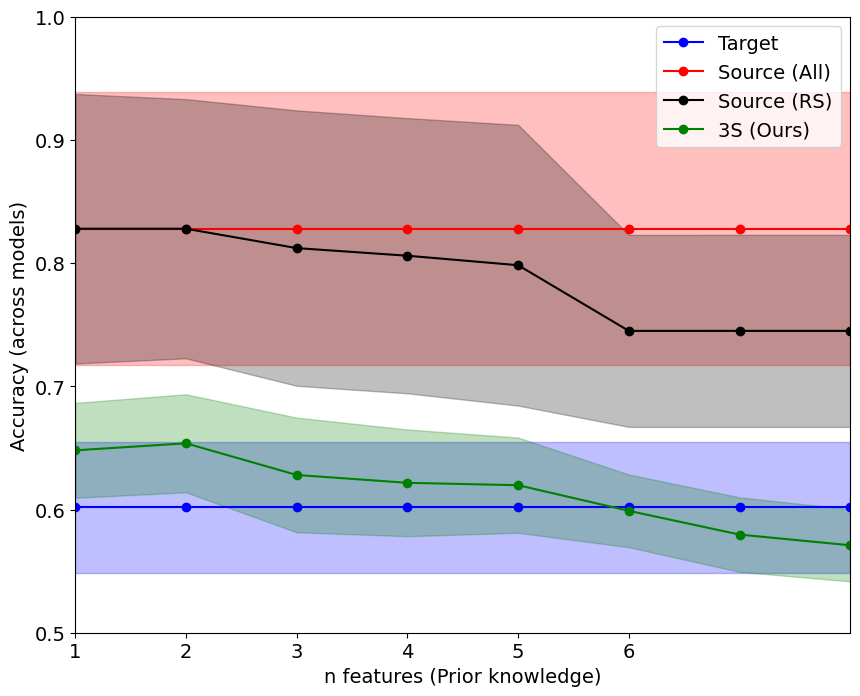

In [15]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.reload_library()

SMALL_SIZE = 10
MEDIUM_SIZE = 50
BIGGER_SIZE = 50

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=14)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=14)  # fontsize of the tick labels
plt.rc("ytick", labelsize=14)  # fontsize of the tick labels
plt.rc("legend", fontsize=14)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(figsize=(10, 8))

plt.plot(x, target_mean, color="b", label="Target", marker="o")
plt.fill_between(
    x, target_mean - target_std, target_mean + target_std, alpha=0.25, color="b"
)

plt.plot(x, source_mean, color="r", label="Source (All)", marker="o")
plt.fill_between(
    x, source_mean - source_std, source_mean + source_std, alpha=0.25, color="r"
)

plt.plot(x, slice_mean, color="k", label="Source (RS)", marker="o")
plt.fill_between(
    x, slice_mean - slice_std, slice_mean + slice_std, alpha=0.25, color="k"
)

plt.plot(x, syn_mean, color="g", label="3S (Ours)", marker="o")
plt.fill_between(x, syn_mean - syn_std, syn_mean + syn_std, alpha=0.25, color="g")
plt.xticks(range(1, 7))

plt.xlim([1, 8])
plt.ylim([0.5, 1])
plt.xlabel("n features (Prior knowledge)")
plt.ylabel("Accuracy (across models)")
plt.legend()


In [16]:
target_model_scores = {}
source_model_scores = {}
syn_model_scores = {}
slice_model_scores = {}
atc_model_scores = {}
atc_mc_model_scores = {}
im_est_model_scores = {}
doc_feat_model_scores = {}

id = 3
for idx, model_name in enumerate(trained_model_dict.keys()):
    target_model_scores[model_name] = target[idx][-2]
    source_model_scores[model_name] = source[idx][-2]
    syn_model_scores[model_name] = syn[idx][-2]
    slice_model_scores[model_name] = train_slice[idx][-2]
    atc_model_scores[model_name] = atc[idx][-2] / 100
    atc_mc_model_scores[model_name] = atc_mc[idx][-2] / 100
    im_est_model_scores[model_name] = im_est[idx][-2] / 100
    doc_feat_model_scores[model_name] = doc_feat[idx][-2] / 100


In [17]:
# 3S
scores_new = sorted(syn_model_scores.items(), key=lambda item: item[1])
syn_res = {}
for score in scores_new:
    syn_res[score[0]] = score[1]

# Source
scores_new = sorted(source_model_scores.items(), key=lambda item: item[1])
all_res = {}
for score in scores_new:
    all_res[score[0]] = score[1]

# Target
scores_new = sorted(target_model_scores.items(), key=lambda item: item[1])
true_res = {}
for score in scores_new:
    true_res[score[0]] = score[1]

# RS
scores_new = sorted(slice_model_scores.items(), key=lambda item: item[1])
RS_res = {}
for score in scores_new:
    RS_res[score[0]] = score[1]

# ATC
scores_new = sorted(atc_model_scores.items(), key=lambda item: item[1])
atc_res = {}
for score in scores_new:
    atc_res[score[0]] = score[1]

# atc-mc
scores_new = sorted(atc_mc_model_scores.items(), key=lambda item: item[1])
atc_mc_res = {}
for score in scores_new:
    atc_mc_res[score[0]] = score[1]

# IM-EST
scores_new = sorted(im_est_model_scores.items(), key=lambda item: item[1])
im_est_res = {}
for score in scores_new:
    im_est_res[score[0]] = score[1]

# Doc-Feat
scores_new = sorted(doc_feat_model_scores.items(), key=lambda item: item[1])
doc_feat_res = {}
for score in scores_new:
    doc_feat_res[score[0]] = score[1]


In [18]:
syn_error = {}
all_error = {}
rs_error = {}
atc_error = {}
atc_mc_error = {}
im_est_error = {}
doc_feat_error = {}

for model in RS_res.keys():
    syn_error[model] = abs(syn_res[model] - true_res[model])
    all_error[model] = abs(all_res[model] - true_res[model])
    rs_error[model] = abs(RS_res[model] - true_res[model])
    atc_error[model] = abs(atc_res[model] - true_res[model])
    atc_mc_error[model] = abs(atc_mc_res[model] - true_res[model])
    im_est_error[model] = abs(im_est_res[model] - true_res[model])
    doc_feat_error[model] = abs(doc_feat_res[model] - true_res[model])

# add means to each dict
syn_error["mean"] = np.mean(list(syn_error.values()))
all_error["mean"] = np.mean(list(all_error.values()))
rs_error["mean"] = np.mean(list(rs_error.values()))
atc_error["mean"] = np.mean(list(atc_error.values()))
atc_mc_error["mean"] = np.mean(list(atc_mc_error.values()))
im_est_error["mean"] = np.mean(list(im_est_error.values()))
doc_feat_error["mean"] = np.mean(list(doc_feat_error.values()))

# add all dicts to a list
error_list = [
    syn_error,
    all_error,
    rs_error,
    atc_error,
    atc_mc_error,
    im_est_error,
    doc_feat_error,
]

# create a dataframe from the list
df = pd.DataFrame(
    error_list,
    index=[
        "3S-Testing",
        "All (Source)",
        "RS (Source)",
        "ATC",
        "ATC_MC",
        "IM_EST",
        "DOC_FEAT",
    ],
)
df


,knn,dt,bag,mlp,rf,gbc,ada,lr,mean
3S-Testing,0.047673,0.045526,0.013172,0.084338,0.031034,0.056501,0.022194,0.044629,0.043133
All (Source),0.177443,0.394295,0.389005,0.227682,0.373212,0.092964,0.102968,0.053297,0.226358
RS (Source),0.038592,0.059819,0.113969,0.264722,0.153873,0.139627,0.190287,0.185474,0.143295
ATC,0.398585,0.419811,0.294811,0.033019,0.226415,0.054245,0.023585,0.075472,0.190743
ATC_MC,0.398585,0.419811,0.294811,0.033019,0.226415,0.054245,0.023585,0.075472,0.190743
IM_EST,0.055491,0.417057,0.363895,0.156323,0.282895,0.033452,0.102968,0.014634,0.178340
DOC_FEAT,0.118639,0.406004,0.264648,0.155708,0.221505,0.030378,0.101987,0.010005,0.163609
